In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
import math
import collections
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def get_states(qc):
    backend = Aer.get_backend('statevector_simulator')
    job = execute(qc, backend)
    result = job.result()
    return result.get_statevector(qc, decimals=3)
    
def print_states(states):
    for i in range(states.shape[0]):
        v = states[i]
        if np.absolute(v) == 0.:
            continue
            
        print(('{:0%db}:' % qc.num_qubits).format(i),
              '{:0.2f}/sqrt(N) @ {:0.2f}pi'.format(np.absolute(v) * math.sqrt(states.shape[0]), np.angle(v) / np.pi))

    print('-----')

In [4]:
def get_counts(qc, shots=8192):
    counts = collections.defaultdict(int)
    backend = Aer.get_backend('qasm_simulator') # the device to run on
    sht = 0
    while sht < shots:
        if sht < shots - 8192:
            s = 8192
        else:
            s = shots - sht
        sht += s
        result = execute(qc, backend, shots=s).result()
        cnt = result.get_counts(qc)
        if len(counts) == 0:
            counts.update(cnt)
        else:
            for key, value in cnt.items():
                counts[key] += value
    
    return counts

In [5]:
def compute_energy(s):
    nside = int(np.sqrt(len(s)))
    bits = np.array([int(x) for x in reversed(s)], dtype=np.int).reshape((nside, nside))
    grid = np.zeros((nside + 1, nside + 1), dtype=np.int)
    grid[:nside, :nside] = bits
    grid[nside, :nside] = bits[0]
    grid[:nside, nside] = bits[:, 0]

    e = 0
    for iy in range(nside):
        for ix in range(nside):
            if grid[iy, ix] == grid[iy, ix + 1]:
                e += 1
            if grid[iy, ix] == grid[iy + 1, ix]:
                e += 1

    return e

In [6]:
def compute_magnetization(s):
    nside = int(np.sqrt(len(s)))
    bits = np.array([2 * int(x) - 1 for x in reversed(s)], dtype=np.int)
    return np.sum(bits)

In [7]:
def get_params(lattice_side):
    params = dict()
    n_spins = lattice_side ** 2
    params['n_spins'] = n_spins
    n_links = n_spins * 2 # periodic boundary condition
    params['n_links'] = n_links
    max_energy = n_links
    params['max_energy'] = max_energy
    min_energy = 0 if lattice_side % 2 == 0 else (2 * lattice_side)
    params['min_energy'] = min_energy
    energy_gap = max_energy - min_energy
    params['energy_gap'] = energy_gap
    log2_data_depth = math.log2(energy_gap // 2) # energy always change by 2 -> compress data
    nq_data = math.ceil(log2_data_depth)
    if nq_data == math.floor(log2_data_depth):
        nq_data += 1
    params['nq_data'] = nq_data

    return params

In [8]:
def ising(lattice_side, K):
    params = get_params(lattice_side)
    n_spins = params['n_spins']
    nq_data = params['nq_data']
    min_energy = params['min_energy']

    state_register = QuantumRegister(n_spins, 'state')
    data_register = QuantumRegister(nq_data, 'data')
    anc_register = QuantumRegister(1, 'anc')
    anc = anc_register[0]
    mmt_register = ClassicalRegister(n_spins + nq_data, 'mmt')

    qc = QuantumCircuit(state_register, data_register, anc_register, mmt_register)

    # Initialize spins to a superposition of all configurations
    for spin in state_register:
        qc.h(spin)

    # Initialize data register also to a full sum from which we reverse Fourier transform
    for data in data_register:
        qc.h(data)

    # Make ancilla rotatable by U1
    qc.x(anc)

    # Encode nearest-neighbor interaction energy as phase
    delta = 2. * math.pi / (2 ** nq_data) / 2 # we want to apply a phase shift by half 2pi/2^d per spin-aligned pair
    for ix, iy in [(ix, iy) for iy in range(lattice_side) for ix in range(lattice_side)]:
        ispin = iy * lattice_side + ix

        for neighbor in [iy * lattice_side + ((ix + 1) % lattice_side), ((iy + 1) % lattice_side) * lattice_side + ix]:
            ctrl_state = [state_register[ispin], state_register[neighbor]]

            for idata in range(nq_data):
                qc.mcu1(delta * (2 ** idata), ctrl_state + [data_register[idata]], anc)

            qc.x(state_register[ispin])
            qc.x(state_register[neighbor])

            for idata in range(nq_data):
                qc.mcu1(delta * (2 ** idata), ctrl_state + [data_register[idata]], anc)

            qc.x(state_register[ispin])
            qc.x(state_register[neighbor])

    # Phase shift to set zero of data register to min_energy
    for idata in range(nq_data):
        qc.cu1(-delta * (2 ** idata) * min_energy, data_register[idata], anc)

    # Inverse Fourier transform - data register now holds half the number of spin-aligned pairs
    for idata in range(nq_data - 1, -1, -1):
        qc.h(data_register[idata])
        for jdata in range(idata - 1, -1, -1):
            qc.cu1(-math.pi / (2 ** (idata - jdata)), data_register[jdata], data_register[idata])

    for idata in range(nq_data // 2):
        qc.swap(data_register[idata], data_register[nq_data - idata - 1])

    # Boltzmann distribution
    for idata in range(nq_data):
        theta = np.arctan(np.exp(K * (2 ** idata) * 0.5))
        qc.h(data_register[idata])
        qc.u1(theta * 2., data_register[idata])
        qc.h(data_register[idata])

    for ispin in range(n_spins):
        qc.measure(state_register[ispin], mmt_register[ispin])
    for idata in range(nq_data):
        qc.measure(data_register[idata], mmt_register[n_spins + idata])
        
    return qc

In [9]:
# states = get_states(qc)

# N = states.shape[0]
# nprint = 0
# for idx, amp in enumerate(states[N // 2:]):
#     if np.absolute(amp) == 0.:
#         continue
#     bitstring = '{:012b}'.format(idx)
#     data = bitstring[:nq_data]
#     state = bitstring[nq_data:]
#     e = compute_energy(state)
#     print(data, state, int(data, 2) * 2 + min_energy, e)


In [10]:
def make_boltzmann(lattice_side, counts):
    params = get_params(lattice_side)
    n_spins = params['n_spins']
    nq_data = params['nq_data']
    min_energy = params['min_energy']
    energy_gap = params['energy_gap']
    
    density_truth = np.zeros(energy_gap // 2 + 1, dtype=np.float)
    form = '{:0%db}' % n_spins
    for i in range(2 ** n_spins):
        e = compute_energy(form.format(i))
        density_truth[(e - min_energy) // 2] += 1.
    density_truth /= (2 ** n_spins)

    zeros = '0' * nq_data
    allcounts = np.zeros(energy_gap // 2 + 1, dtype=np.float)
    density = np.zeros(energy_gap // 2 + 1, dtype=np.float)
    for key, value in counts.items():
        if key[:nq_data] != zeros:
            continue
        e = compute_energy(key[nq_data:])
        idx = (e - min_energy) // 2
        allcounts[idx] += value
        density[idx] += 1
        
    allcounts /= np.sum(allcounts)

    histogram = np.zeros_like(allcounts)
    #np.divide(allcounts, density, out=histogram, where=(density != 0))
    np.divide(allcounts, density_truth, out=histogram, where=(density != 0))
    
    return histogram

In [16]:
def make_magnetization(lattice_side, counts):
    params = get_params(lattice_side)
    n_spins = params['n_spins']
    nq_data = params['nq_data']
    
    zeros = '0' * nq_data
    histogram = np.zeros(n_spins + 1, dtype=np.float)
    for key, value in counts.items():
        if key[:nq_data] != zeros:
            continue
        m = compute_magnetization(key[nq_data:])
        idx = (m + n_spins) // 2
        histogram[idx] += value

    return histogram

In [ ]:
lattice_side = 3
K = 1.
qc = ising(lattice_side, K)
counts = get_counts(qc, shots=(8192 * 16))
histogram = make_boltzmann(lattice_side, counts)

In [ ]:
params = get_params(lattice_side)
fig, ax = plt.subplots()
ax.bar(np.arange(params['min_energy'], params['max_energy'] + 1, 2), histogram)
ax.plot([params['min_energy'], params['max_energy']], [histogram[0], histogram[-1]], linestyle='--', color='red')
ax.set_yscale('log')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('a.u.')
fig.show()

In [21]:
# Plot magnetization for several Ks
lattice_side = 3
K = 2.
qc = ising(lattice_side, K)
counts = get_counts(qc, shots=(8192 * 16))
histogram = make_magnetization(lattice_side, counts)

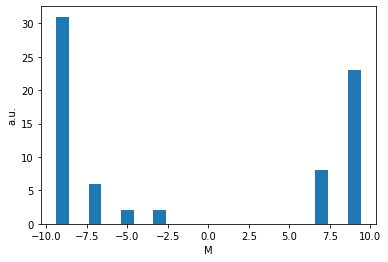

In [22]:
params = get_params(lattice_side)
fig, ax = plt.subplots()
ax.bar(np.arange(-params['n_spins'], params['n_spins'] + 1, 2), histogram)
ax.set_xlabel('M')
ax.set_ylabel('a.u.')
fig.show()